## Case 2: Financial Distress

### Authors:
Team 4:
- Stephen Panev
- Marin St
- Dayana Hristova
- Dimitar Lyubchev

In [1]:
import pandas as pd
import numpy as np
from numpy import arange, argmax

import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.base import BaseEstimator
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE


pd.set_option("display.max_columns", 90)
pd.set_option("display.max_rows", 185)


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("data/Financial Distress.csv")

### Transform the target into 0s and 1s

Here the new labels will be as follows: <br>

- 0s represent a healthy company
- 1s represent a company in a bad shape(or already in bankrupt)

In [3]:
def new_labels(row):
    return 0 if row["Financial Distress"] > -0.5 else 1

In [4]:
df["Financial Distress"] = df.apply(new_labels, axis=1)

In [5]:
df["Financial Distress"].value_counts()

0    3536
1     136
Name: Financial Distress, dtype: int64

### Split the data into train and test sets

In [6]:
X = df.iloc[:,3:]
Y = df["Financial Distress"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42, stratify=Y)

In [8]:
test_data = pd.concat([X_test, y_test], axis=1)
test_data.sort_index(inplace=True)

In [9]:
X_train.sort_index(inplace=True)
y_train.sort_index(inplace=True)
train_data = pd.concat([X_train, y_train], axis=1)

<ipython-input-9-2444e6b3f6d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.sort_index(inplace=True)


In [10]:
y_train.value_counts()

0    2475
1      95
Name: Financial Distress, dtype: int64

In [11]:
X_train.describe().loc[["min", "max", "mean"]]

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
min,0.075170,-0.258080,0.016135,5.350000e-07,-0.269790,-0.627750,0.035160,-2424.000000,-3.611200,-0.318660,0.021491,-2.620000e+06,0.032101,0.016400,4.090000e-06,-35758.000000,0.000000,0.000287,0.000000,0.000603,0.000003,8.300000e-07,-0.553850,0.016135,-3374.600000,8.913600,-8408.400000,-0.499440,0.000000,0.009655,0.000000e+00,0.010060,0.093000,0.000087,0.000000e+00,-0.669790,0.000000,0.000654,-0.999970,0.000172,0.000002,-214.820000,0.093283,-56.719000,-9.376900,-0.642120,1.640100e-02,540.030000,0.016400,0.000000,0.000000,-33563.000000,-0.225220,0.010753,-1.000000,0.000000,-0.998610,-0.251620,-15649.000000,-0.349060,-7.714000,-11.824000,-25.736000,-21.411000,-21.907000,15.916000,10.300000,7941.800000,-58.122000,10.400000,-10.66500,0.000000,22.00000,54.806000,24.31800,23.776000,15.250000,12.000000,-20.200000,1.000000,-0.499220,1.000000,2.00000
max,51.954000,0.749410,0.967900,6.835600e+00,0.858540,0.929550,38.836000,209000.000000,3.810200,0.754720,0.998100,3.830000e+07,0.983860,30.152000,3.960000e+06,4.256500,376000.000000,0.596550,139000.000000,5.964600,11.791000,1.072100e+04,1.000000,0.935630,79551.000000,19.106000,9327.400000,4.625400,0.690460,0.948000,3.610000e+08,312000.000000,1.000000,929000.000000,8.790000e+07,5.766100,10.536000,15772.000000,290000.000000,0.977760,56.913000,482.600000,5731.700000,3201.900000,6.052400,34.063000,1.660000e+06,136000.000000,19.625000,1.553800,19.809000,7.194000,0.831470,342000.000000,1.000000,0.806430,1182.800000,0.158980,1.402900,0.456550,7.416600,15.381000,14.321000,18.770000,124.760000,39.432000,13.850000,34501.000000,364.950000,34.700000,61.47600,4.000000,36.75000,120.870000,227.50000,214.500000,22.000000,22.000000,8.600000,37.000000,128.400000,49.000000,74.00000
mean,1.393862,0.131112,0.613699,8.787745e-01,0.156467,0.108482,0.788832,99.264453,0.335644,0.137137,0.639605,1.476873e+05,0.386301,2.405937,9.655989e+03,-46.369858,1005.421038,0.040925,54.152401,0.101509,1.462342,1.382808e+01,0.273408,0.531123,1009.039232,13.290533,-2.570403,0.204692,0.082576,0.354070,3.864456e+05,418.696115,0.864512,1747.894028,5.866119e+04,0.245213,0.306462,14.701566,132.026377,0.257989,3.043834,0.729885,9.967409,3.286366,0.153302,0.304594,2.129072e+03,2492.036848,2.099476,0.726592,12.949861,-42.720129,0.209373,3486.341781,0.011341,0.237821,1.015156,-0.010228,-9.800332,0.113358,2.630187,3.343767,1.238582,-0.801112,30.760031,28.232829,11.450993,15968.195759,20.539936,17.808042,23.11801,1.922856,30.39434,86.707257,92.60106,89.736143,17.808251,15.219304,-2.588737,19.658366,1.105555,13.184825,33.26965


## Standardization of the data

In [12]:
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(data=X_train_sc, columns=X_train.columns)
y_train_scaled = y_train.values.ravel()


### Recursive Feature Elimination

I am going to use RFE, because RFE is an effective algorithm that allows to directly select the desired number of features. For analysis I am going to use the Logistic Regression model.

In [13]:
logreg = LogisticRegression(max_iter=1000)

X_train_cols = X_train.columns.values.tolist()
y_train_cols = y_train.name
X_train_cols_arr = np.array(X_train_cols)

def rf_elimination(X, y, n_features=15):

    rfe = RFE(logreg, n_features_to_select=n_features)
    rfe = rfe.fit(X, y.values.ravel())

    mask = rfe.support_
    
    X_rfe_cols = X_train_cols_arr[mask]
    
    return list(X_rfe_cols)

In [14]:
selected_cols = rf_elimination(X_train_scaled, y_train)

In [15]:
selected_cols

['x3',
 'x5',
 'x10',
 'x13',
 'x15',
 'x17',
 'x20',
 'x21',
 'x24',
 'x25',
 'x33',
 'x44',
 'x48',
 'x54',
 'x58']

### Data binning

Here I am going to plot the selected features using histograms and stacked bar plots and see if we can get some insights

In [16]:
X_train_rfe = X_train[selected_cols]
X_train_rfe.shape

(2570, 15)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D23A190>,
      dtype=object)

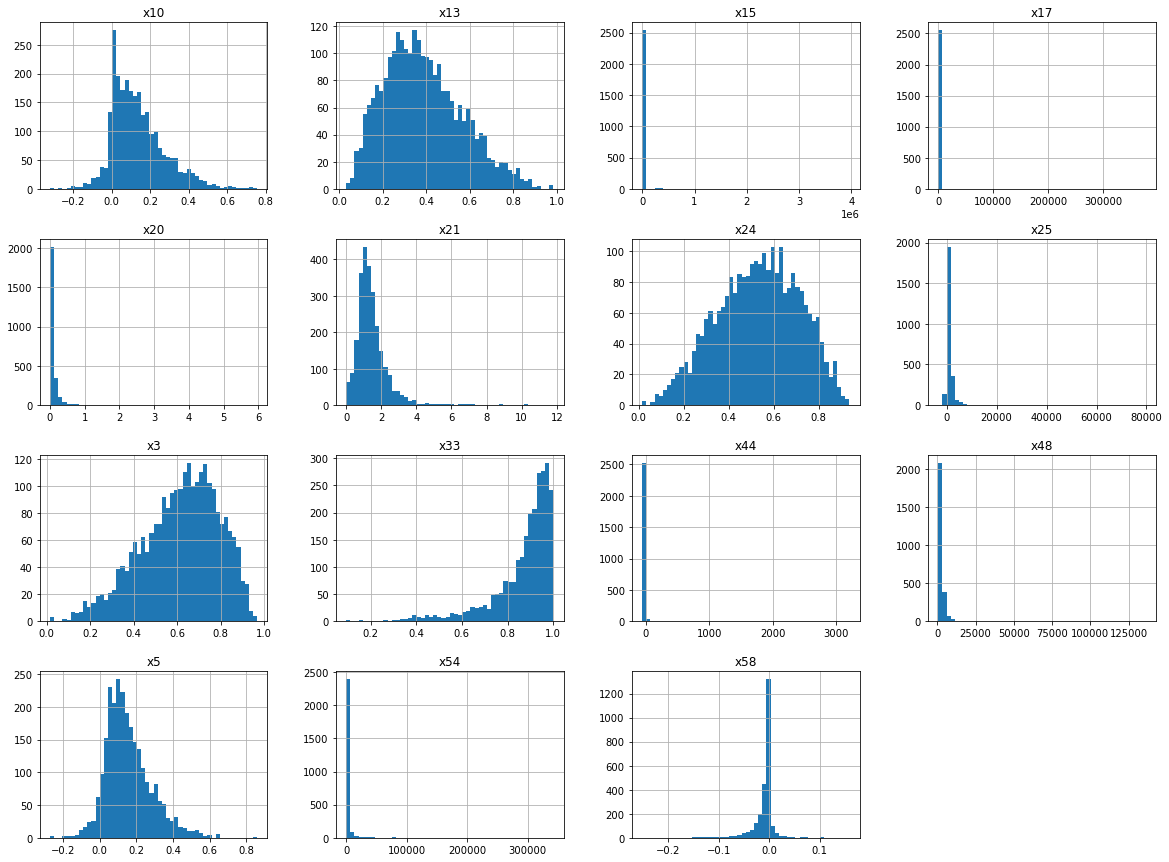

In [17]:
X_train_rfe.hist(bins=50, figsize=(20,15))

In [18]:
bin_cols = []
def data_binning_cols(features, quantiles):
    

    for feature in features:
        X_train_rfe[feature + "_bins"] = pd.qcut(X_train_rfe[feature], q=quantiles, duplicates="drop")
        bin_cols.append(feature + "_bins")
        
        
data_binning_cols(selected_cols, quantiles=[0, .25, .5, .75, 1.])

<ipython-input-18-5fbdca6b335b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_rfe[feature + "_bins"] = pd.qcut(X_train_rfe[feature], q=quantiles, duplicates="drop")


In [19]:
def plot_binned_cols(data, columns, n=1):
    
    plt.figure(figsize=(20,50))
    
    for col in columns:
        
        
        plt.subplot(8,2,n)
#         pd.crosstab(X_train_rfe[col],y_train).plot.barh(ax=plt.gca())
        pd.crosstab(X_train_rfe[col],y_train).plot(kind='barh', stacked=True, ax=plt.gca())
        plt.title(col)
        
        n += 1

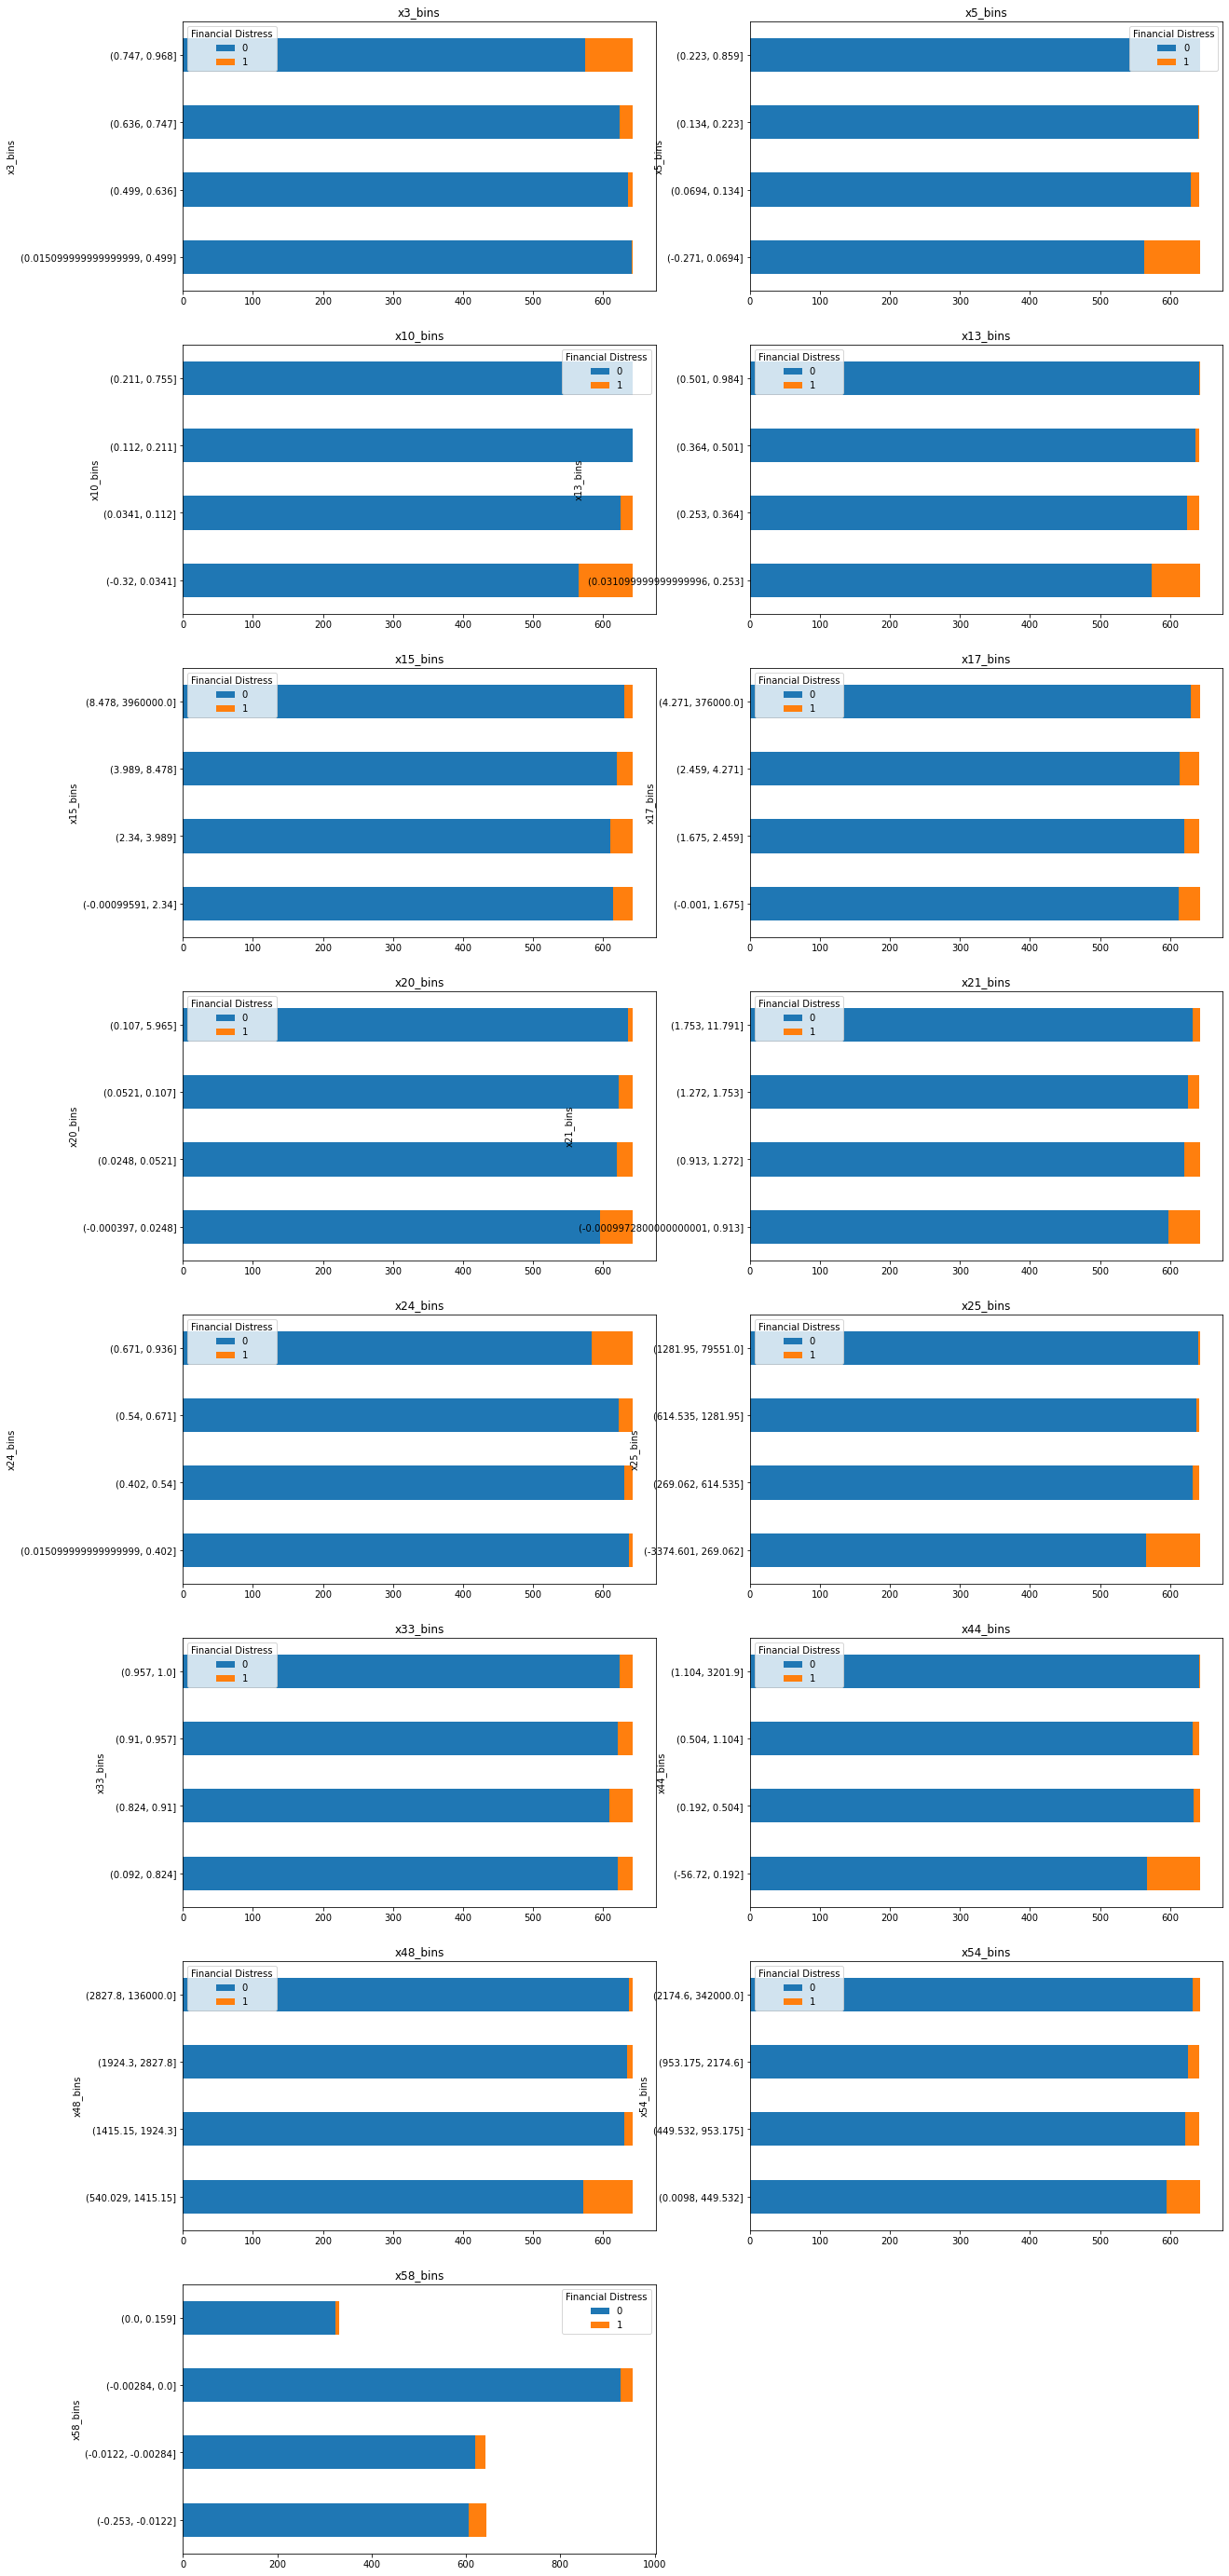

In [20]:
plot_binned_cols(X_train_rfe, columns=bin_cols)

From the stacked bar charts it looks like that features x_15 and x_17 might not be good predictors and therefore would be removed

In [21]:
selected_cols_final = [col for col in selected_cols if col not in ["x15", "x17"]]

In [22]:
X_train_rfe = X_train[selected_cols_final]
X_train_rfe.shape

(2570, 13)

## Over-sampling

I am going to balance the target classes by oversampling the training data. For this I am going to use SMOTE algorithm

In [23]:
os = SMOTE(random_state=42)

os_data_X_tr, os_data_y_tr = os.fit_sample(X_train_rfe, y_train)
os_data_X_tr = pd.DataFrame(data=os_data_X_tr ,columns=X_train_rfe.columns)
os_data_y_tr = pd.DataFrame(data=os_data_y_tr, columns=["Financial Distress"])


# we can Check the numbers of our data

print("Length of the normal data: ",len(X_train_rfe))

print("Length of the oversampled data: ",len(os_data_X_tr))

print("Number of 0s before: ", len(y_train[y_train==0]))

print("Number of 0s in oversampled data: ",
      len(os_data_y_tr[os_data_y_tr["Financial Distress"]==0]))

print("Number of 1s before: ", len(y_train[y_train==1]))

print("Number of 1s in oversampled data: ",len(os_data_y_tr[os_data_y_tr["Financial Distress"]==1]))


print("Proportion of 0s in oversampled data is: ",
      len(os_data_y_tr[os_data_y_tr["Financial Distress"]==0])/len(os_data_X_tr))

print("Proportion of 1s in oversampled data is: ",
      len(os_data_y_tr[os_data_y_tr["Financial Distress"]==1])/len(os_data_X_tr))



Length of the normal data:  2570
Length of the oversampled data:  4950
Number of 0s before:  2475
Number of 0s in oversampled data:  2475
Number of 1s before:  95
Number of 1s in oversampled data:  2475
Proportion of 0s in oversampled data is:  0.5
Proportion of 1s in oversampled data is:  0.5


In [24]:
os_X_train_rfe = os_data_X_tr
os_y_train_values = os_data_y_tr.values.ravel()

### Test some models

In [25]:
log_reg_clf = LogisticRegression(max_iter=10000)
forest_clf = RandomForestClassifier(n_estimators=10, random_state=24)
gr_boost_clf = GradientBoostingClassifier()

In [26]:
def select_model(model, X, y, predict_proba=False):
    
    model.fit(X, y)
    model_score = cross_val_score(model, X, y, cv=10, scoring="accuracy")
    
    y_model_predict = cross_val_predict(model, X, y, cv=10)
    
    if predict_proba:
        y_probas = cross_val_predict(model, X, y, cv=10,
                             method="predict_proba")
        y_scores = y_probas[:, 1]
    else:
        y_scores = cross_val_predict(model, X, y, cv=10,
                             method="decision_function")
    
    
    conf_matrix = confusion_matrix(y, y_model_predict)
    precision_sc = precision_score(y, y_model_predict)
    recall_sc = recall_score(y, y_model_predict)
    f1_sc = f1_score(y, y_model_predict)
    
    
    print(f" Results for the {model} are:")
    print()
    print(f" Accuracy score: {model_score.mean()}")
    print()
    print(f" Confusion matrix: \n {conf_matrix}")
    print()
    print(f" Precision: {precision_sc}")
    print(f" Recall: {recall_sc}")
    print(f" F1 score: {f1_sc}")
    
    return y_scores, y_model_predict

In [27]:
y_scores_log_reg, y_predict_log_reg = select_model(log_reg_clf, os_X_train_rfe, os_y_train_values)

 Results for the LogisticRegression(max_iter=10000) are:

 Accuracy score: 0.8686868686868687

 Confusion matrix: 
 [[2092  383]
 [ 267 2208]]

 Precision: 0.8521806252412196
 Recall: 0.8921212121212121
 F1 score: 0.8716936439005133


In [28]:
y_scores_forest, y_predict_forest = select_model(forest_clf, os_X_train_rfe, os_y_train_values, predict_proba=True)

 Results for the RandomForestClassifier(n_estimators=10, random_state=24) are:

 Accuracy score: 0.968888888888889

 Confusion matrix: 
 [[2354  121]
 [  33 2442]]

 Precision: 0.9527896995708155
 Recall: 0.9866666666666667
 F1 score: 0.9694323144104804


In [29]:
y_scores_grb, y_predict_grb = select_model(gr_boost_clf, os_X_train_rfe, os_y_train_values, predict_proba=True)

 Results for the GradientBoostingClassifier() are:

 Accuracy score: 0.9391919191919191

 Confusion matrix: 
 [[2226  249]
 [  52 2423]]

 Precision: 0.906811377245509
 Recall: 0.978989898989899
 F1 score: 0.9415193316495045


### Precision-Recall and ROC Curves

Below there is a comparison for all of the models with the usage of PR and ROC Curves

In [30]:
precisions_log_reg, recalls_log_reg, thresholds_log_reg = precision_recall_curve(os_y_train_values, y_scores_log_reg)
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(os_y_train_values, y_scores_forest)
precisions_grb, recalls_grb, thresholds_grb = precision_recall_curve(os_y_train_values, y_scores_grb)

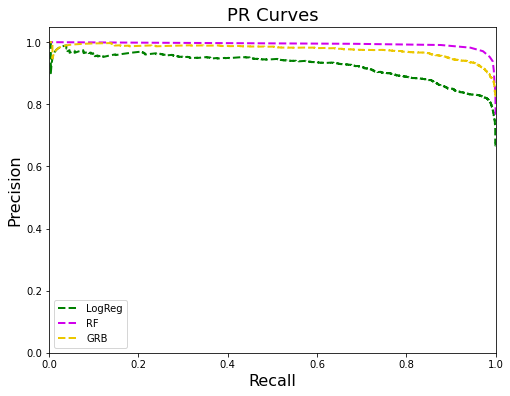

In [31]:
def plot_precision_vs_recall(precisions, recalls, color="g", label=None):
    plt.plot(recalls, precisions, color=color, linestyle='dashed', linewidth=2, label=label)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.title("PR Curves", fontsize=18)
    plt.ylim(0, 1.05)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions_log_reg, recalls_log_reg, color="g", label="LogReg")
plot_precision_vs_recall(precisions_forest, recalls_forest, color="#d000eb", label="RF")
plot_precision_vs_recall(precisions_grb, recalls_grb, color="#ebc700", label="GRB")
plt.legend()
plt.show()

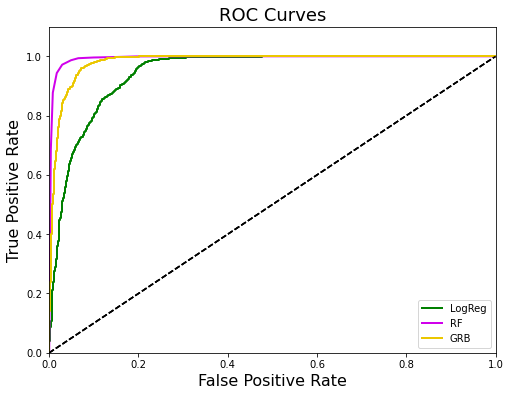

In [32]:
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(os_y_train_values, y_scores_log_reg)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(os_y_train_values, y_scores_forest)
fpr_grb, tpr_grb, thresholds_grb = roc_curve(os_y_train_values, y_scores_grb)

def plot_roc_curve(fpr, tpr, color="g", label=None):
    plt.plot(fpr, tpr, linewidth=2, color=color, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title("ROC Curves", fontsize=18)
    plt.ylim(0, 1.1)

plt.figure(figsize=(8, 6))

plot_roc_curve(fpr_log_reg, tpr_log_reg, color="g", label="LogReg")
plot_roc_curve(fpr_forest, tpr_forest, color="#d000eb", label="RF")
plot_roc_curve(fpr_grb, tpr_grb, color="#ebc700", label="GRB")

plt.legend()
plt.show()

In [33]:
print(f" ROC AUC Score LogReg: {roc_auc_score(os_y_train_values, y_scores_log_reg)}")
print(f" ROC AUC Score RF: {roc_auc_score(os_y_train_values, y_scores_forest)}")
print(f" ROC AUC Score GRB: {roc_auc_score(os_y_train_values, y_scores_grb)}")

 ROC AUC Score LogReg: 0.9445793694520966
 ROC AUC Score RF: 0.9943190286705439
 ROC AUC Score GRB: 0.9826169574533211


## Make predictions with all classifiers

In [34]:
X_test_final = X_test[selected_cols_final]

In [35]:
X_test_final.shape

(1102, 13)

In [36]:
y_log_reg_predict = log_reg_clf.predict(X_test_final)
n_correct_log_reg = sum(y_log_reg_predict == y_test)
y_log_reg_predict_proba = log_reg_clf.predict_proba(X_test_final)
y_log_reg_predict_proba = y_log_reg_predict_proba[:, 1]


y_forest_predict = forest_clf.predict(X_test_final)
n_correct_forest = sum(y_forest_predict == y_test)
y_forest_predict_proba = forest_clf.predict_proba(X_test_final)
y_forest_predict_proba = y_forest_predict_proba[:, 1]


y_grb_predict = gr_boost_clf.predict(X_test_final)
n_correct_grb = sum(y_grb_predict == y_test)
y_grb_predict_proba = gr_boost_clf.predict_proba(X_test_final)
y_grb_predict_proba = y_grb_predict_proba[:, 1]

print("Prediction Scores:")
print(f"LogReg: {(n_correct_log_reg / len(y_log_reg_predict))}")
print(f"RF: {(n_correct_forest / len(y_forest_predict))}")
print(f"GRB: {(n_correct_grb / len(y_grb_predict))}")

Prediction Scores:
LogReg: 0.8357531760435571
RF: 0.9382940108892922
GRB: 0.8920145190562614


### ROC Curve after predictions

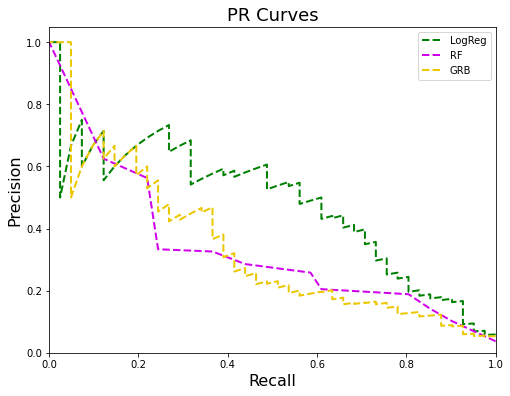

In [37]:
precisions_log_reg_test, recalls_log_reg_test, thresholds_log_reg_test = precision_recall_curve(y_test, y_log_reg_predict_proba)
precisions_forest_test, recalls_forest_test, thresholds_forest_test = precision_recall_curve(y_test, y_forest_predict_proba)
precisions_grb_test, recalls_grb_test, thresholds_grb_test = precision_recall_curve(y_test, y_grb_predict_proba)


plt.figure(figsize=(8, 6))

plot_precision_vs_recall(precisions_log_reg_test, recalls_log_reg_test, color="g", label="LogReg")
plot_precision_vs_recall(precisions_forest_test, recalls_forest_test, color="#d000eb", label="RF")
plot_precision_vs_recall(precisions_grb_test, recalls_grb_test, color="#ebc700", label="GRB")

plt.legend()
plt.show()

In [38]:
print(f" PR AUC Score LogReg: {auc(recalls_log_reg_test, precisions_log_reg_test)}")
print(f" PR AUC Score RF: {auc(recalls_forest_test, precisions_forest_test)}")
print(f" PR AUC Score GRB: {auc(recalls_grb_test, precisions_grb_test)}")

 PR AUC Score LogReg: 0.47532707993764134
 PR AUC Score RF: 0.3351371294066806
 PR AUC Score GRB: 0.33221354380294177


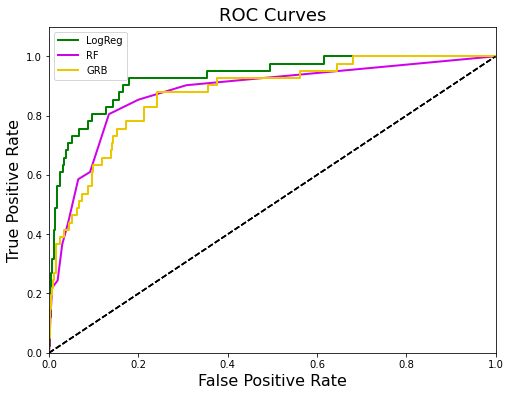

In [39]:
fpr_log_reg_test, tpr_log_reg_test, thresholds_log_reg_test = roc_curve(y_test, y_log_reg_predict_proba)
fpr_forest_test, tpr_forest_test, thresholds_forest_test = roc_curve(y_test, y_forest_predict_proba)
fpr_grb_test, tpr_grb_test, thresholds_grb_test = roc_curve(y_test, y_grb_predict_proba)


plt.figure(figsize=(8, 6))

plot_roc_curve(fpr_log_reg_test, tpr_log_reg_test, color="g", label="LogReg")
plot_roc_curve(fpr_forest_test, tpr_forest_test, color="#d000eb", label="RF")
plot_roc_curve(fpr_grb_test, tpr_grb_test, color="#ebc700", label="GRB")

plt.legend()
plt.show()

In [40]:
print(f" ROC AUC Score LogReg: {roc_auc_score(y_test, y_log_reg_predict)}")
print(f" ROC AUC Score RF: {roc_auc_score(y_test, y_forest_predict)}")
print(f" ROC AUC Score GRB: {roc_auc_score(y_test, y_grb_predict)}")

 ROC AUC Score LogReg: 0.867807636606055
 ROC AUC Score RF: 0.6983057860738834
 ROC AUC Score GRB: 0.7328911979034965


#### Try to improve models performance on PR Curve by changing their decision boundaries

Check the probability distribution for the positive target class

Text(0.5, 1.0, 'Probability dist of 1s')

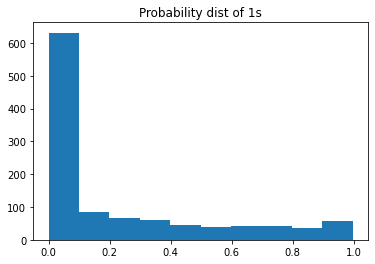

In [41]:
plt.hist(y_log_reg_predict_proba)
plt.title("Probability dist of 1s")

#### Calculate all possible thresholds and get the ones that result in the best f1 score measure for each model

In [42]:
# define possible thresholds
thresholds = arange(0, 1, 0.001)

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')


probas_list = [y_log_reg_predict_proba, y_forest_predict_proba, 
               y_grb_predict_proba]

def threshold_eval(probas_list):
    
    scores_list = []
    for prob in probas_list:
        
        scores_cust = [f1_score(y_test, to_labels(prob, t)) for t in thresholds]
        scores_list.append(scores_cust)
    
    return tuple(scores_list)

In [43]:
scores_log_reg, scores_forest, scores_grb, = threshold_eval(probas_list)

In [44]:
list_of_scores = [scores_log_reg, scores_forest, scores_grb]

In [45]:
def get_best_thresholds(list_of_scores):
    
    n = 0
    print_list = ["LogReg:", "RF:", "GRB:"]
    for s in list_of_scores:
        
        
        ix = argmax(s)
        print(print_list[n])
        print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], s[ix]))
        print()
        n += 1

In [46]:
# Check the f1 scores first:
print(f" F1 Score LogReg: {f1_score(y_test, y_log_reg_predict)}")
print(f" F1 Score RF: {f1_score(y_test, y_forest_predict)}")
print(f" F1 Score GRB: {f1_score(y_test, y_grb_predict)}")

 F1 Score LogReg: 0.2901960784313726
 F1 Score RF: 0.34615384615384615
 F1 Score GRB: 0.27878787878787875


In [47]:
get_best_thresholds(list_of_scores)

LogReg:
Threshold=0.916, F-Score=0.55422

RF:
Threshold=0.401, F-Score=0.35821

GRB:
Threshold=0.899, F-Score=0.41096



The above results show that if we change the thresholds from 0.5 the F-Scores could be improved by some margin

#### Log Reg with new threshold

In [48]:
log_reg_threshold = 0.916
log_reg_new_preds = np.where(log_reg_clf.predict_proba(X_test_final)[:,1] > log_reg_threshold, 1, 0)

In [49]:
n_correct_log_reg_new = sum(log_reg_new_preds == y_test)
log_reg_predict_proba_new = log_reg_clf.predict_proba(X_test_final)

print(f"Old_Prediction_LogReg: {(n_correct_log_reg / len(y_log_reg_predict))}")
print(f"New_Prediction_LogReg: {(n_correct_log_reg_new / len(log_reg_new_preds))}")

Old_Prediction_LogReg: 0.8357531760435571
New_Prediction_LogReg: 0.9664246823956443


In [50]:
precisions_log_reg_test_new, recalls_log_reg_test_new, thresholds_log_reg_test_new = precision_recall_curve(y_test, log_reg_new_preds)

In [51]:
print(f" Old Confusion matrix:   \n  {confusion_matrix(y_test, y_log_reg_predict)}")
print()
print(f" New Confusion matrix:   \n  {confusion_matrix(y_test, log_reg_new_preds)}")

 Old Confusion matrix:   
  [[884 177]
 [  4  37]]

 New Confusion matrix:   
  [[1042   19]
 [  18   23]]


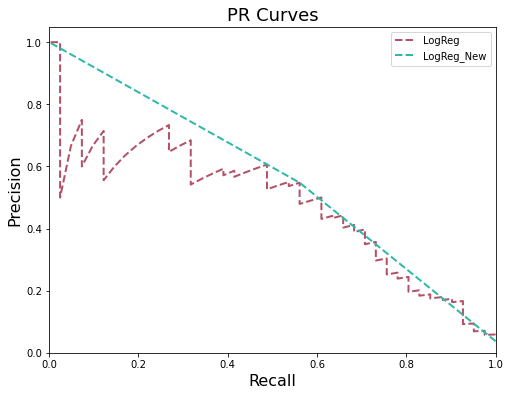

AUC LogReg: 0.47532707993764134
AUC LogReg_New: 0.5624642978345781


In [52]:
plt.figure(figsize=(8, 6))

plot_precision_vs_recall(precisions_log_reg_test, recalls_log_reg_test, color="#b55167", label="LogReg")
plot_precision_vs_recall(precisions_log_reg_test_new, recalls_log_reg_test_new, color="#2eb8aa", label="LogReg_New")
plt.legend()
plt.show()

print(f"AUC LogReg: {auc(recalls_log_reg_test, precisions_log_reg_test)}")
print(f"AUC LogReg_New: {auc(recalls_log_reg_test_new, precisions_log_reg_test_new)}")

#### Random Forest with new threshold

In [53]:
rf_threshold = 0.401
rf_new_preds = np.where(forest_clf.predict_proba(X_test_final)[:,1] > rf_threshold, 1, 0)

In [54]:
n_correct_rf_new = sum(rf_new_preds == y_test)
rf_predict_proba_new = forest_clf.predict_proba(X_test_final)

print(f"Old_Prediction_RF: {(n_correct_forest / len(y_forest_predict))}")
print(f"New_Prediction_RF: {(n_correct_rf_new / len(rf_new_preds))}")

Old_Prediction_RF: 0.9382940108892922
New_Prediction_RF: 0.9219600725952813


In [55]:
precisions_rf_test_new, recalls_rf_test_new, thresholds_rf_test_new = precision_recall_curve(y_test, rf_new_preds)

In [56]:
print(f" Old Confusion matrix:   \n  {confusion_matrix(y_test, y_forest_predict)}")
print()
print(f" New Confusion matrix:   \n  {confusion_matrix(y_test, rf_new_preds)}")

 Old Confusion matrix:   
  [[1016   45]
 [  23   18]]

 New Confusion matrix:   
  [[992  69]
 [ 17  24]]


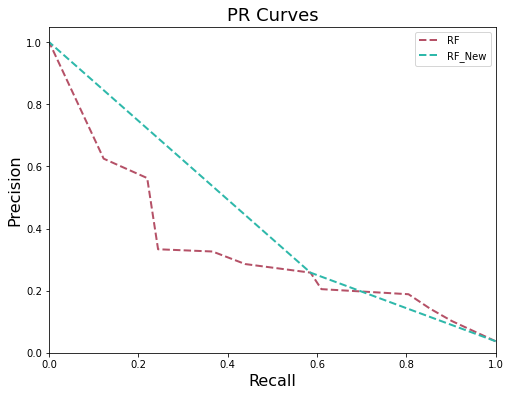

AUC Random_Forest: 0.3351371294066806
AUC Random_Forest_New: 0.42942843353262283


In [57]:
plt.figure(figsize=(8, 6))

plot_precision_vs_recall(precisions_forest_test, recalls_forest_test, color="#b55167", label="RF")
plot_precision_vs_recall(precisions_rf_test_new, recalls_rf_test_new, color="#2eb8aa", label="RF_New")
plt.legend()
plt.show()

print(f"AUC Random_Forest: {auc(recalls_forest_test, precisions_forest_test)}")
print(f"AUC Random_Forest_New: {auc(recalls_rf_test_new, precisions_rf_test_new)}")

#### Gradient Boost with new threshold

In [58]:
gr_threshold = 0.899
gr_new_preds = np.where(gr_boost_clf.predict_proba(X_test_final)[:,1] > gr_threshold, 1, 0)

In [59]:
n_correct_gr_new = sum(gr_new_preds == y_test)
gr_predict_proba_new = gr_boost_clf.predict_proba(X_test_final)

print(f"Old_Prediction_GRB: {(n_correct_grb / len(y_grb_predict))}")
print(f"New_Prediction_GRB: {(n_correct_gr_new / len(gr_new_preds))}")

Old_Prediction_GRB: 0.8920145190562614
New_Prediction_GRB: 0.9609800362976406


In [60]:
precisions_gr_test_new, recalls_gr_test_new, thresholds_gr_test_new = precision_recall_curve(y_test, gr_new_preds)

In [61]:
print(f" Old Confusion matrix:   \n  {confusion_matrix(y_test, y_grb_predict)}")
print()
print(f" New Confusion matrix:   \n  {confusion_matrix(y_test, gr_new_preds)}")

 Old Confusion matrix:   
  [[960 101]
 [ 18  23]]

 New Confusion matrix:   
  [[1044   17]
 [  26   15]]


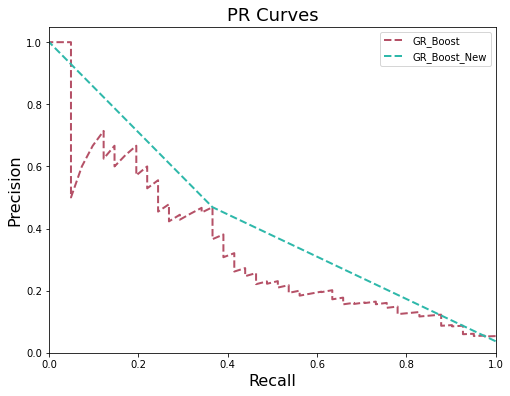

AUC GR_Boost: 0.33221354380294177
AUC GR_Boost_New: 0.4290985624806339


In [62]:
plt.figure(figsize=(8, 6))

plot_precision_vs_recall(precisions_grb_test, recalls_grb_test, color="#b55167", label="GR_Boost")
plot_precision_vs_recall(precisions_gr_test_new, recalls_gr_test_new, color="#2eb8aa", label="GR_Boost_New")
plt.legend()
plt.show()

print(f"AUC GR_Boost: {auc(recalls_grb_test, precisions_grb_test)}")
print(f"AUC GR_Boost_New: {auc(recalls_gr_test_new, precisions_gr_test_new)}")

### Final prediction scores and performance measures

In [63]:
print(f"New_Prediction_LogReg: {(n_correct_log_reg_new / len(log_reg_new_preds))}")
print(f"New_Prediction_RF: {(n_correct_rf_new / len(rf_new_preds))}")
print(f"New_Prediction_GRB: {(n_correct_gr_new / len(gr_new_preds))}")

New_Prediction_LogReg: 0.9664246823956443
New_Prediction_RF: 0.9219600725952813
New_Prediction_GRB: 0.9609800362976406


#### Plot all models on the PR Curve

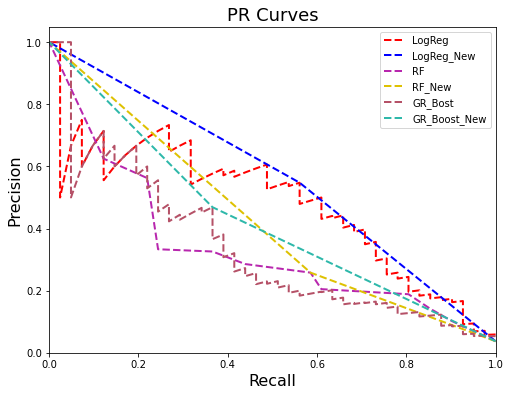

AUC LogReg: 0.47532707993764134
AUC LogReg_New: 0.5624642978345781
AUC Random_Forest: 0.3351371294066806
AUC Random_Forest_New: 0.42942843353262283
AUC GR_Boost: 0.33221354380294177
AUC GR_Boost_New: 0.4290985624806339


In [64]:
plt.figure(figsize=(8, 6))

plot_precision_vs_recall(precisions_log_reg_test, recalls_log_reg_test, color="r", label="LogReg")
plot_precision_vs_recall(precisions_log_reg_test_new, recalls_log_reg_test_new, color="b", label="LogReg_New")

plot_precision_vs_recall(precisions_forest_test, recalls_forest_test, color="#b827ae", label="RF")
plot_precision_vs_recall(precisions_rf_test_new, recalls_rf_test_new, color="#dec102", label="RF_New")

plot_precision_vs_recall(precisions_grb_test, recalls_grb_test, color="#b55167", label="GR_Bost")
plot_precision_vs_recall(precisions_gr_test_new, recalls_gr_test_new, color="#2eb8aa", label="GR_Boost_New")
plt.legend()
plt.show()

print(f"AUC LogReg: {auc(recalls_log_reg_test, precisions_log_reg_test)}")
print(f"AUC LogReg_New: {auc(recalls_log_reg_test_new, precisions_log_reg_test_new)}")

print(f"AUC Random_Forest: {auc(recalls_forest_test, precisions_forest_test)}")
print(f"AUC Random_Forest_New: {auc(recalls_rf_test_new, precisions_rf_test_new)}")

print(f"AUC GR_Boost: {auc(recalls_grb_test, precisions_grb_test)}")
print(f"AUC GR_Boost_New: {auc(recalls_gr_test_new, precisions_gr_test_new)}")




### Conclusion

The task was to select the most important features and the best model to predict if a company will be on its way to bankruptcy or not. <br>

After comparing 3 different models for prediction, the results show that: <br>

- All of the models perform very well on the test data (with 92% prediction accuracy  or above)
- The models do not handle the unbalanced test data well

Furthermore, because target classes distribution is skewed, the ROC Curve on the final predictions could be misleading for the models performances. <br>

In this case the Precision-Recall Curve is the better metric to use, because it focuses more on how a model is performing on the positive instances (which are the minority class) while ROC Curve should be used for more balanced datasets.<br>

One possibility for improvement was to change the default thresholds for prediction (0.5) so that the models perform better. In order to do that I had to check lots of threshold values from 0 to 1 and get the one that results in the best f1 score for each model <br>

- The reason for using an f1 score as a performance measure is that in this task we are not specifically focused on the TPR or the precision and the f1 score is known as the harmonic mean that balances both scores.

- The results show that after changing the decision boundaries, each of the three models performs better.

Finally, the goal of this notebook is to show an example of how to deal with a binary classification problem for an unbalanced dataset, and a classification model's performance could be improved simply by changing its decision boundary.

If we want to achieve better results, possible solutions could be: <br>

- Use the time feature and select only the last time period for each company (results in a balanced data which is easier to handle for analysis and predictions
- Create more than two target classes (the distribution of the target variables allows for a good split of three or four equally distributed targets)
- Leave the targets as they are, drop the categorical variable x80 and classify the problem as a Regression problem (Ridge and Lasso Regression could be used for Feature engineering which could improve the final results significantly)
